In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.patches import Rectangle

## Pam measurement annotations

In [2]:
x = np.linspace(0, 30)
y = x**2

lights = [10, 20, 30]
times = [(0, 10), (10, 20), (20, 30)]

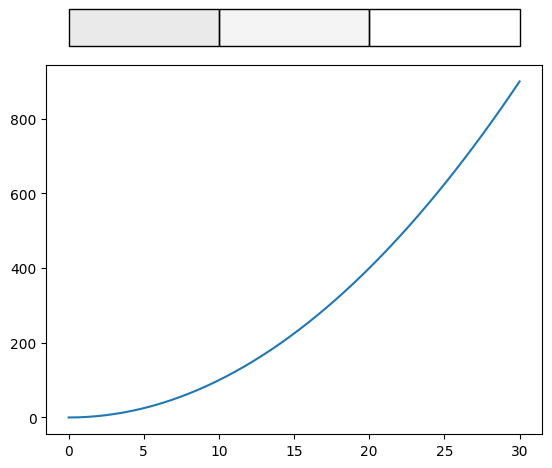

In [3]:
def pam_annotation(ax, lights, times, edgecolor=None):
    max_pfd = max(lights)
    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    for pfd, (t_start, t_end) in zip(lights, times):
        ax.add_patch(
            Rectangle(
                (t_start, 1.05),
                width=t_end - t_start,
                height=0.1,
                transform=trans,
                clip_on=False,
                facecolor=(0, 0, 0, 1 / 8 * (1 - pfd / max_pfd)),
                edgecolor=edgecolor,
            )
        )


fig, ax = plt.subplots()
ax.plot(x, y)
pam_annotation(ax, lights, times, edgecolor="black")

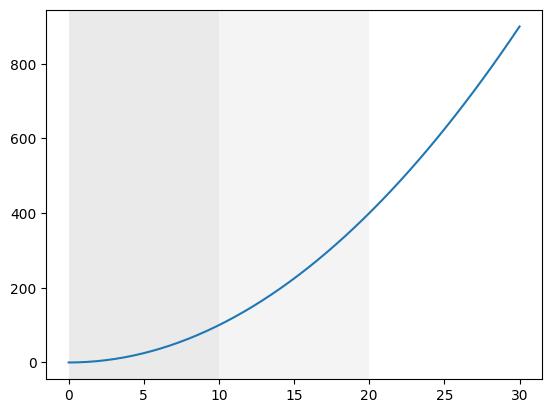

In [4]:
def shade_light(ax, lights, times, edgecolor=None):
    max_pfd = max(lights)
    for pfd, (t_start, t_end) in zip(lights, times):
        ax.axvspan(
            t_start,
            t_end,
            facecolor=(0, 0, 0, 1 / 8 * (1 - pfd / max_pfd)),
            edgecolor=edgecolor,
        )


fig, ax = plt.subplots()
ax.plot(x, y)
shade_light(ax, lights, times)

## Pokeplot

/tmp/ipykernel_10287/1226658651.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap_name)


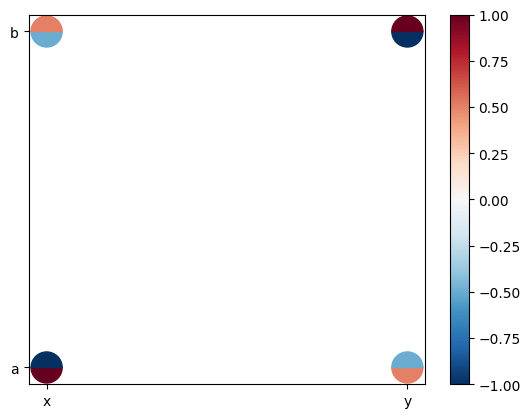

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.colors import Normalize
from matplotlib.markers import MarkerStyle
from matplotlib.cm import get_cmap, ScalarMappable
from numpy.typing import ArrayLike



def symmetric_vmin_vmax(df: ArrayLike) -> dict[str, float]:
    vmax = np.nanmax(df)
    vmin = np.nanmin(df)
    v = max(abs(vmin), abs(vmax))
    return {"vmin": -v, "vmax": v}


df1 = pd.DataFrame(
    {
        "a": {"x": 1, "y": 0.5},
        "b": {"x": -0.5, "y": -1},
    }
)

df2 = pd.DataFrame(
    {
        "a": {"x": -1, "y": -0.5},
        "b": {"x": 0.5, "y": 1},
    }
)

norm = Normalize(**symmetric_vmin_vmax([df1, df2]))
cmap_name = "RdBu_r"

cmap = get_cmap(cmap_name)

df_melt = pd.melt(df1, ignore_index=False).reset_index()
fig, ax = plt.subplots()
ax.scatter(
    x=df_melt["index"],
    y=df_melt["variable"],
    s=500,
    c=cmap(norm(df_melt["value"])),
    marker=MarkerStyle("o", fillstyle="bottom"),
)

df_melt = pd.melt(df2, ignore_index=False).reset_index()
ax.scatter(
    x=df_melt["index"],
    y=df_melt["variable"],
    s=500,
    c=cmap(norm(df_melt["value"])),
    marker=MarkerStyle("o", fillstyle="top"),
)
fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax)
plt.show()


## Pandas multi-index to 3D plot

k1:   0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

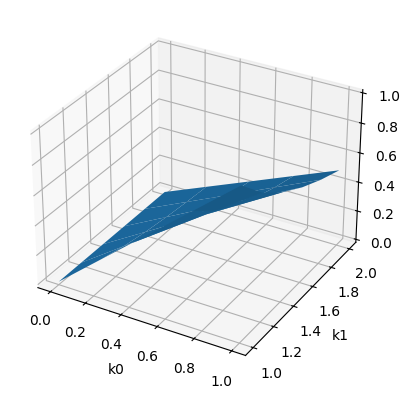

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from modelbase.ode import Model, Simulator


def index2d_to_meshgrid(
    df: pd.DataFrame,
    nx: int | None = None,
    ny: int | None = None,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    l1 = df.index.get_level_values(1)
    l0 = df.index.get_level_values(0)

    if nx is None:
        nx = len(l1.unique())
    if ny is None:
        ny = len(l0.unique())

    x = l1.to_numpy().reshape(-1, nx)
    y = l0.to_numpy().reshape(ny, -1)
    z = df.to_numpy().reshape(ny, nx)
    return x, y, z


def constant(x: float) -> float:
    return x


def mass_action(x: float, k: float) -> float:
    return k * x


m = Model()
m.add_compound("x")
m.add_parameters({"k0": 1, "k1": 1})
m.add_reaction_from_args("v0", constant, {"x": 1}, ["k0"])
m.add_reaction_from_args("v1", mass_action, {"x": -1}, ["x", "k1"])
s = Simulator(m)
s.initialise({"x": 0})
scan = s.parameter_scan_2d(
    ("k0", np.linspace(0, 1, 5)),
    ("k1", np.linspace(1, 2, 6)),
)
df = pd.concat(scan)["x"]

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(*index2d_to_meshgrid(df))
ax.set_xlabel("k0")
ax.set_ylabel("k1")
plt.show()

## Auto-grid

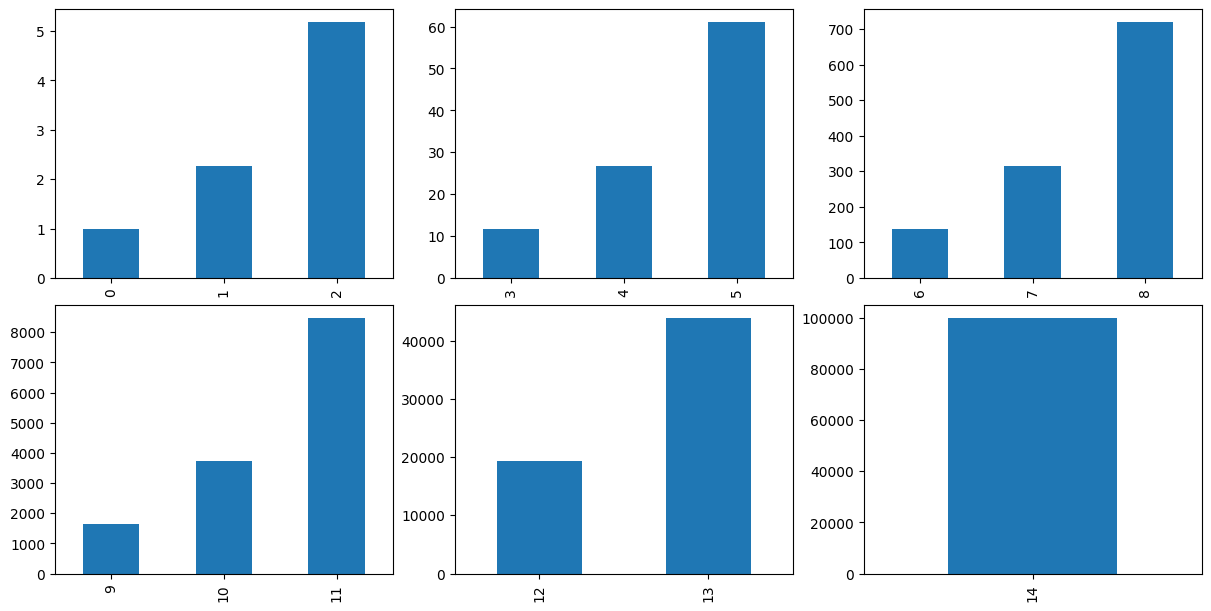

In [7]:
import math
import numpy as np
import pandas as pd
import itertools as it
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from typing import Literal, TypeVar

T = TypeVar("T")


def partition_by_order_of_magnitude(s: pd.Series) -> list[list[str]]:
    return [
        i.to_list()
        for i in np.floor(np.log10(s)).to_frame(name=0).groupby(0)[0].groups.values()  # type: ignore
    ]


def split_large_groups(groups: list[list[T]], max_size: int = 4) -> list[list[T]]:
    return list(
        it.chain(
            *(
                [group]
                if len(group) < max_size
                else [
                    list(i)
                    for i in np.array_split(group, math.ceil(len(group) / max_size))
                ]
                for group in groups
            )
        )
    )  # type: ignore


def subplot_layout(
    n_groups: int, n_cols: int = 2, col_width: int = 3, row_height: int = 4
) -> tuple[Figure, list[Axes]]:
    from math import ceil

    n_rows = ceil(n_groups / n_cols)
    fig, axs = plt.subplots(
        n_rows,
        n_cols,
        figsize=(n_cols * col_width, n_rows * row_height),
        layout="constrained",
        squeeze=False,
    )
    return fig, axs.flatten()


def plot_autogrid(
    s: pd.Series | pd.DataFrame,
    plot_kind: Literal[
        "line",
        "bar",
        "barh",
        "hist",
        "box",
        "kde",
        "density",
        "area",
        "pie",
        "scatter",
        "hexbin",
    ],
    n_cols: int = 2,
    col_width: int = 4,
    row_height: int = 3,
    max_group_size: int = 6,
) -> tuple[Figure, list[Axes]]:
    if isinstance(s, pd.Series):
        groups = partition_by_order_of_magnitude(s)
    else:
        groups = partition_by_order_of_magnitude(s.max())

    groups = split_large_groups(groups, max_size=max_group_size)
    fig, axs = subplot_layout(
        len(groups), n_cols=n_cols, col_width=col_width, row_height=row_height
    )

    if isinstance(s, pd.Series):
        for ax, group in zip(axs, groups):
            s.loc[group].plot(kind=plot_kind, ax=ax)
    else:
        for ax, group in zip(axs, groups):
            s.loc[:, group].plot(kind=plot_kind, ax=ax)
    return fig, axs


fig, axs = plot_autogrid(
    pd.Series(np.geomspace(1, 1e5, 15)),
    plot_kind="bar",
    n_cols=3,
)